# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [11]:
#Name
ModelName = 'titanic_propensity_survive'

#Setting the model target variable name
VarTarget = 'Survived'
VarId = 'PassengerId'
VarDate = 'ReferenceDate' 

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'Ticket_str'
,'NameTitle']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean'
,'Ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [12]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [13]:
dataprep_df_full = pd.read_csv('./titanic/dataprep_df.csv')

In [14]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [15]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

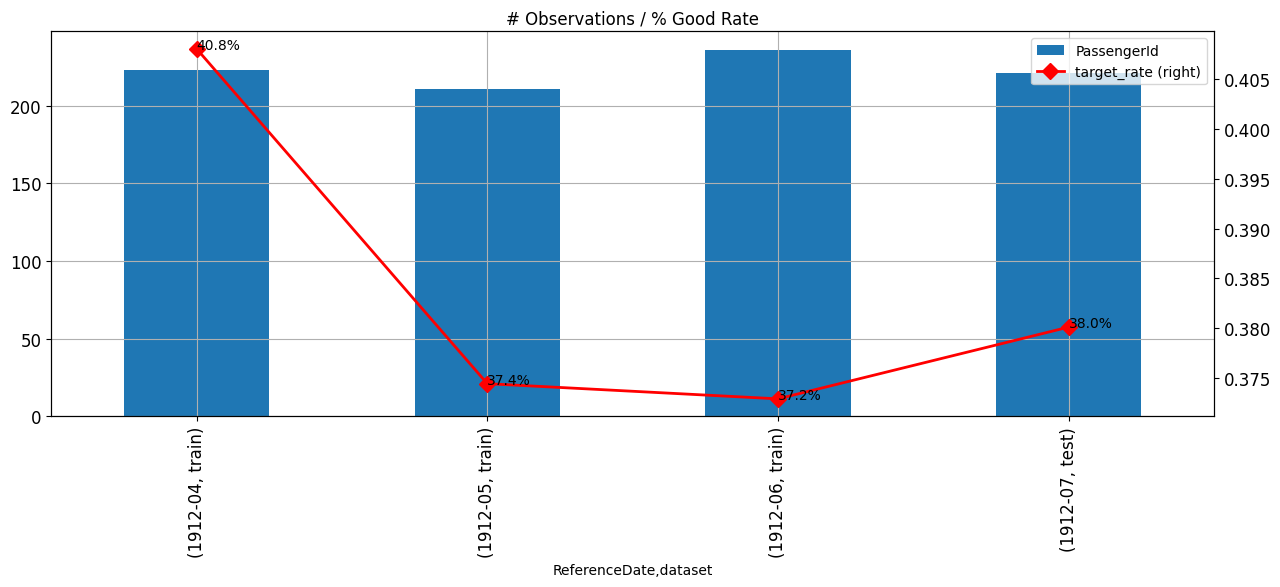

In [16]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]

dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [17]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [18]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [19]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [20]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_4k1lo5k
  JVM stdout: /tmp/tmp_4k1lo5k/h2o_azureuser_started_from_python.out
  JVM stderr: /tmp/tmp_4k1lo5k/h2o_azureuser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 9 days !!!
H2O_cluster_name:,H2O_from_python_azureuser_khend1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,982 Mb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [22]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 606
Validation: 64


In [23]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 221


## 4.2.2 Train the H2O Champion algorithm with new data

In [24]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:03.519481

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_titanic_propensity_survive_v1_20221117_234843


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,4724.0,1.0,4.0,2.391304,2.0,5.0,3.478261




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13232521640738032
RMSE: 0.3637653315083508
LogLoss: 0.4276191766246271
Mean Per-Class Error: 0.1789475489691606
AUC: 0.8871851165769042
AUCPR: 0.8703138396331312
Gini: 0.7743702331538085

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45297853775574104: 


,,0,1,Error,Rate
0,0,307.0,62.0,0.168,(62.0/369.0)
1,1,45.0,192.0,0.1899,(45.0/237.0)
2,Total,352.0,254.0,0.1766,(107.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.452979,0.782077,196.0
1,max f2,0.231690,0.833333,269.0
2,max f0point5,0.575104,0.842044,130.0
3,max accuracy,0.575104,0.830033,130.0
4,max precision,0.884329,1.000000,0.0
5,max recall,0.107404,1.000000,382.0
6,max specificity,0.884329,1.000000,0.0
7,max absolute_mcc,0.575104,0.649598,130.0
8,max min_per_class_accuracy,0.452979,0.810127,196.0
9,max mean_per_class_accuracy,0.452979,0.821052,196.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 39.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.876839,2.556962,2.556962,1.000000,0.879147,1.000000,0.879147,0.029536,0.029536,155.696203,155.696203,0.029536
1,2,0.023102,0.870695,2.556962,2.556962,1.000000,0.872225,1.000000,0.875686,0.029536,0.059072,155.696203,155.696203,0.059072
2,3,0.031353,0.862939,2.556962,2.556962,1.000000,0.864483,1.000000,0.872738,0.021097,0.080169,155.696203,155.696203,0.080169
3,4,0.042904,0.857056,2.556962,2.556962,1.000000,0.859535,1.000000,0.869183,0.029536,0.109705,155.696203,155.696203,0.109705
4,5,0.051155,0.849836,2.556962,2.556962,1.000000,0.853247,1.000000,0.866613,0.021097,0.130802,155.696203,155.696203,0.130802
5,6,0.100660,0.809671,2.471730,2.515045,0.966667,0.829498,0.983607,0.848360,0.122363,0.253165,147.172996,151.504462,0.250455
6,7,0.150165,0.719194,2.471730,2.500765,0.966667,0.767243,0.978022,0.821618,0.122363,0.375527,147.172996,150.076506,0.370107
7,8,0.201320,0.678573,2.309514,2.452168,0.903226,0.699917,0.959016,0.790694,0.118143,0.493671,130.951409,145.216850,0.480121
8,9,0.301980,0.537829,1.718614,2.207650,0.672131,0.585055,0.863388,0.722148,0.172996,0.666667,71.861382,120.765027,0.598916
9,10,0.400990,0.458892,1.108017,1.936136,0.433333,0.491496,0.757202,0.665197,0.109705,0.776371,10.801688,93.613585,0.616480




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13286589438064314
RMSE: 0.3645077425523951
LogLoss: 0.4322506204551996
Mean Per-Class Error: 0.15448504983388703
AUC: 0.8549280177187153
AUCPR: 0.8006545519549297
Gini: 0.7098560354374306

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5655004314881706: 


,,0,1,Error,Rate
0,0,42.0,1.0,0.0233,(1.0/43.0)
1,1,6.0,15.0,0.2857,(6.0/21.0)
2,Total,48.0,16.0,0.1094,(7.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.565500,0.810811,14.0
1,max f2,0.187841,0.787402,41.0
2,max f0point5,0.565500,0.882353,14.0
3,max accuracy,0.565500,0.890625,14.0
4,max precision,0.876231,1.000000,0.0
5,max recall,0.109647,1.000000,54.0
6,max specificity,0.876231,1.000000,0.0
7,max absolute_mcc,0.565500,0.749308,14.0
8,max min_per_class_accuracy,0.496688,0.761905,19.0
9,max mean_per_class_accuracy,0.565500,0.845515,14.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 38.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.875897,3.047619,3.047619,1.000000,0.876231,1.000000,0.876231,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.865948,3.047619,3.047619,1.000000,0.875700,1.000000,0.875966,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.842320,0.000000,3.047619,0.000000,0.000000,1.000000,0.875966,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.837780,3.047619,3.047619,1.000000,0.838194,1.000000,0.863375,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.078125,0.837398,1.523810,2.438095,0.500000,0.837398,0.800000,0.852984,0.047619,0.190476,52.380952,143.809524,0.167220
5,6,0.109375,0.816478,3.047619,2.612245,1.000000,0.822002,0.857143,0.844132,0.095238,0.285714,204.761905,161.224490,0.262458
6,7,0.156250,0.733405,3.047619,2.742857,1.000000,0.783246,0.900000,0.825866,0.142857,0.428571,204.761905,174.285714,0.405316
7,8,0.203125,0.682898,3.047619,2.813187,1.000000,0.696253,0.923077,0.795955,0.142857,0.571429,204.761905,181.318681,0.548173
8,9,0.296875,0.508101,1.523810,2.406015,0.500000,0.591323,0.789474,0.731335,0.142857,0.714286,52.380952,140.601504,0.621262
9,10,0.406250,0.409500,0.435374,1.875458,0.142857,0.463291,0.615385,0.659169,0.047619,0.761905,-56.462585,87.545788,0.529347




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.14696841987050635
RMSE: 0.3833646043527054
LogLoss: 0.46621474333425866
Mean Per-Class Error: 0.20709409625741826
AUC: 0.8586497890295359
AUCPR: 0.820253017350523
Gini: 0.7172995780590719

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.411276986263452: 


,,0,1,Error,Rate
0,0,280.0,89.0,0.2412,(89.0/369.0)
1,1,41.0,196.0,0.173,(41.0/237.0)
2,Total,321.0,285.0,0.2145,(130.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.411277,0.750958,214.0
1,max f2,0.304601,0.820312,251.0
2,max f0point5,0.565321,0.813288,129.0
3,max accuracy,0.565321,0.815182,129.0
4,max precision,0.895488,1.000000,0.0
5,max recall,0.075327,1.000000,394.0
6,max specificity,0.895488,1.000000,0.0
7,max absolute_mcc,0.565321,0.613518,129.0
8,max min_per_class_accuracy,0.425492,0.780591,202.0
9,max mean_per_class_accuracy,0.411277,0.792906,214.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 39.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.880973,2.191682,2.191682,0.857143,0.885734,0.857143,0.885734,0.025316,0.025316,119.168174,119.168174,0.022606
1,2,0.021452,0.867710,2.130802,2.163583,0.833333,0.874944,0.846154,0.880754,0.021097,0.046414,113.080169,116.358325,0.040993
2,3,0.031353,0.854798,2.130802,2.153231,0.833333,0.857472,0.842105,0.873402,0.021097,0.067511,113.080169,115.323118,0.059380
3,4,0.041254,0.835255,2.556962,2.250127,1.000000,0.844498,0.880000,0.866465,0.025316,0.092827,155.696203,125.012658,0.084697
4,5,0.051155,0.812767,2.556962,2.309514,1.000000,0.824023,0.903226,0.858250,0.025316,0.118143,155.696203,130.951409,0.110013
5,6,0.100660,0.751924,2.556962,2.431210,1.000000,0.783918,0.950820,0.821693,0.126582,0.244726,155.696203,143.120979,0.236596
6,7,0.150165,0.697415,2.471730,2.444568,0.966667,0.726364,0.956044,0.790266,0.122363,0.367089,147.172996,144.456809,0.356248
7,8,0.201320,0.629355,2.144549,2.368334,0.838710,0.658443,0.926230,0.756770,0.109705,0.476793,114.454880,136.833368,0.452403
8,9,0.300330,0.533019,1.534177,2.093337,0.600000,0.578315,0.818681,0.697939,0.151899,0.628692,53.417722,109.333704,0.539261
9,10,0.400990,0.460005,1.173687,1.862479,0.459016,0.493491,0.728395,0.646616,0.118143,0.746835,17.368749,86.247851,0.567974




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.806923,0.056262,0.811475,0.793388,0.727273,0.884298,0.818182
1,auc,0.861467,0.045810,0.877922,0.831281,0.818565,0.933188,0.846377
2,err,0.193077,0.056262,0.188525,0.206612,0.272727,0.115702,0.181818
3,err_count,23.400000,6.804411,23.000000,25.000000,33.000000,14.000000,22.000000
4,f0point5,0.751225,0.093724,0.734694,0.774193,0.612583,0.873786,0.760870
5,f1,0.768190,0.053446,0.757895,0.793388,0.691589,0.837209,0.760870
6,f2,0.790920,0.020336,0.782609,0.813559,0.793991,0.803571,0.760870
7,lift_top_group,2.587828,0.298486,2.711111,2.086207,2.880952,2.630435,2.630435
8,logloss,0.462268,0.051764,0.424920,0.524087,0.490635,0.395224,0.476476
9,max_per_class_error,0.249809,0.060681,0.200000,0.238095,0.354430,0.217391,0.239130



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-11-17 23:48:46,2.453 sec,0.0,0.487994,0.669233,0.500000,0.391089,1.000000,0.608911,0.473734,0.641356,0.500000,0.328125,1.000000,0.671875
1,,2022-11-17 23:48:46,2.487 sec,5.0,0.467256,0.627852,0.731290,0.653532,2.220520,0.339934,0.446987,0.589447,0.797896,0.626670,2.285714,0.218750
2,,2022-11-17 23:48:46,2.505 sec,10.0,0.426588,0.550744,0.831681,0.813398,2.556962,0.204620,0.408794,0.519605,0.853821,0.781713,3.047619,0.125000
3,,2022-11-17 23:48:46,2.524 sec,15.0,0.413021,0.524842,0.848610,0.828721,2.556962,0.212871,0.396092,0.495762,0.853821,0.795260,3.047619,0.125000
4,,2022-11-17 23:48:46,2.550 sec,20.0,0.393306,0.486876,0.869576,0.846853,2.556962,0.227723,0.382324,0.468471,0.856589,0.809012,3.047619,0.109375
5,,2022-11-17 23:48:46,2.570 sec,25.0,0.381208,0.463499,0.877346,0.855342,2.556962,0.214521,0.375702,0.454822,0.852713,0.807810,3.047619,0.109375
6,,2022-11-17 23:48:46,2.595 sec,30.0,0.379167,0.458808,0.878952,0.858777,2.556962,0.198020,0.372258,0.448646,0.851606,0.797787,3.047619,0.109375
7,,2022-11-17 23:48:46,2.617 sec,35.0,0.372927,0.446289,0.881754,0.862931,2.556962,0.189769,0.369393,0.442358,0.853821,0.798980,3.047619,0.109375
8,,2022-11-17 23:48:46,2.638 sec,40.0,0.369203,0.438956,0.884995,0.867202,2.556962,0.179868,0.368545,0.440784,0.853821,0.798572,3.047619,0.109375
9,,2022-11-17 23:48:46,2.660 sec,45.0,0.365040,0.430416,0.885779,0.868948,2.556962,0.178218,0.364773,0.432901,0.853821,0.799720,3.047619,0.109375



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,NameTitle,201.414749,1.000000,0.601302
1,Pclass,42.053246,0.208789,0.125545
2,Ticket_int,31.617002,0.156975,0.094389
3,cabine_prefix,25.752705,0.127859,0.076882
4,Fare,19.935818,0.098979,0.059516
5,Embarked,5.669171,0.028147,0.016925
6,Age_Mean,4.922785,0.024441,0.014696
7,Parch,1.344442,0.006675,0.004014
8,SibSp,1.301227,0.006460,0.003885
9,Ticket_str,0.953422,0.004734,0.002846


## 4.2.3 Using H2O AutoML to performe all algorithms

In [25]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
23:48:54.827: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:04.154803



In [26]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_1_20221117_234854,0.862852,0.878693,0.412667,0.178398,0.354977,0.126009
GBM_grid_1_AutoML_1_20221117_234854_model_13,0.85382,0.86605,0.426893,0.193387,0.362932,0.13172
StackedEnsemble_BestOfFamily_3_AutoML_1_20221117_234854,0.853389,0.869743,0.417459,0.182047,0.357732,0.127972
XGBoost_3_AutoML_1_20221117_234854,0.852389,0.864399,0.4295,0.18435,0.361514,0.130692
GBM_grid_1_AutoML_1_20221117_234854_model_8,0.852225,0.866267,0.431876,0.198384,0.366509,0.134329
StackedEnsemble_AllModels_3_AutoML_1_20221117_234854,0.851696,0.869917,0.413352,0.179745,0.355516,0.126392
XGBoost_grid_1_AutoML_1_20221117_234854_model_4,0.850869,0.863095,0.431267,0.183003,0.363149,0.131877
GBM_grid_1_AutoML_1_20221117_234854_model_1,0.85076,0.868657,0.434888,0.185306,0.368505,0.135796
GBM_grid_1_AutoML_1_20221117_234854_model_9,0.84778,0.866354,0.429445,0.175139,0.364334,0.132739
GBM_2_AutoML_1_20221117_234854,0.845966,0.859663,0.431468,0.189911,0.365912,0.133892


In [27]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_4_AutoML_1_20221117_234854

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04240261969167044
RMSE: 0.20591896389519457
LogLoss: 0.17144025069132934
Null degrees of freedom: 605
Residual degrees of freedom: 600
Null deviance: 811.1101129160465
Residual deviance: 207.78558383789118
AIC: 219.78558383789118
AUC: 0.9911838358889918
AUCPR: 0.9882441402176602
Gini: 0.9823676717779837

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35882288467581464: 


,,0,1,Error,Rate
0,0,352.0,17.0,0.0461,(17.0/369.0)
1,1,10.0,227.0,0.0422,(10.0/237.0)
2,Total,362.0,244.0,0.0446,(27.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.358823,0.943867,191.0
1,max f2,0.323797,0.953372,199.0
2,max f0point5,0.641900,0.971831,159.0
3,max accuracy,0.423422,0.955446,181.0
4,max precision,0.989897,1.000000,0.0
5,max recall,0.128087,1.000000,265.0
6,max specificity,0.989897,1.000000,0.0
7,max absolute_mcc,0.358823,0.907208,191.0
8,max min_per_class_accuracy,0.358823,0.953930,191.0
9,max mean_per_class_accuracy,0.358823,0.955868,191.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 38.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.986385,2.556962,2.556962,1.000000,0.988166,1.000000,0.988166,0.029536,0.029536,155.696203,155.696203,0.029536
1,2,0.021452,0.981070,2.556962,2.556962,1.000000,0.983721,1.000000,0.986114,0.025316,0.054852,155.696203,155.696203,0.054852
2,3,0.031353,0.979905,2.556962,2.556962,1.000000,0.980521,1.000000,0.984348,0.025316,0.080169,155.696203,155.696203,0.080169
3,4,0.041254,0.977061,2.556962,2.556962,1.000000,0.978530,1.000000,0.982952,0.025316,0.105485,155.696203,155.696203,0.105485
4,5,0.051155,0.972592,2.556962,2.556962,1.000000,0.974685,1.000000,0.981352,0.025316,0.130802,155.696203,155.696203,0.130802
5,6,0.100660,0.951005,2.556962,2.556962,1.000000,0.962014,1.000000,0.971841,0.126582,0.257384,155.696203,155.696203,0.257384
6,7,0.150165,0.928346,2.556962,2.556962,1.000000,0.939084,1.000000,0.961042,0.126582,0.383966,155.696203,155.696203,0.383966
7,8,0.201320,0.885950,2.556962,2.556962,1.000000,0.910171,1.000000,0.948116,0.130802,0.514768,155.696203,155.696203,0.514768
8,9,0.300330,0.770673,2.556962,2.556962,1.000000,0.838867,1.000000,0.912100,0.253165,0.767932,155.696203,155.696203,0.767932
9,10,0.400990,0.358895,1.844366,2.378080,0.721311,0.579321,0.930041,0.828563,0.185654,0.953586,84.436605,137.807991,0.907516




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.11072665919635125
RMSE: 0.33275615576026724
LogLoss: 0.3799056713394681
Null degrees of freedom: 63
Residual degrees of freedom: 58
Null deviance: 82.09360090171138
Residual deviance: 48.62792593145193
AIC: 60.62792593145193
AUC: 0.8648947951273532
AUCPR: 0.8488911349050059
Gini: 0.7297895902547065

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6489485073793705: 


,,0,1,Error,Rate
0,0,41.0,2.0,0.0465,(2.0/43.0)
1,1,5.0,16.0,0.2381,(5.0/21.0)
2,Total,46.0,18.0,0.1094,(7.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.648949,0.820513,17.0
1,max f2,0.648949,0.784314,17.0
2,max f0point5,0.747443,0.882353,15.0
3,max accuracy,0.747443,0.890625,15.0
4,max precision,0.988216,1.000000,0.0
5,max recall,0.034707,1.000000,60.0
6,max specificity,0.988216,1.000000,0.0
7,max absolute_mcc,0.747443,0.749308,15.0
8,max min_per_class_accuracy,0.648949,0.761905,17.0
9,max mean_per_class_accuracy,0.648949,0.857697,17.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 32.94 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.985381,3.047619,3.047619,1.000000,0.988216,1.000000,0.988216,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.981285,3.047619,3.047619,1.000000,0.983715,1.000000,0.985966,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.975395,0.000000,3.047619,0.000000,0.000000,1.000000,0.985966,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.971535,3.047619,3.047619,1.000000,0.974366,1.000000,0.982099,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.062500,0.968735,3.047619,3.047619,1.000000,0.968922,1.000000,0.978805,0.047619,0.190476,204.761905,204.761905,0.190476
5,6,0.109375,0.935611,3.047619,3.047619,1.000000,0.949103,1.000000,0.966075,0.142857,0.333333,204.761905,204.761905,0.333333
6,7,0.156250,0.901256,3.047619,3.047619,1.000000,0.918869,1.000000,0.951914,0.142857,0.476190,204.761905,204.761905,0.476190
7,8,0.203125,0.785412,2.031746,2.813187,0.666667,0.840811,0.923077,0.926275,0.095238,0.571429,103.174603,181.318681,0.548173
8,9,0.296875,0.494844,2.031746,2.566416,0.666667,0.693910,0.842105,0.852896,0.190476,0.761905,103.174603,156.641604,0.692137
9,10,0.406250,0.209782,0.000000,1.875458,0.000000,0.298152,0.615385,0.703542,0.000000,0.761905,-100.000000,87.545788,0.529347




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.11555509822089902
RMSE: 0.33993396155856365
LogLoss: 0.3787900332456082
Null degrees of freedom: 605
Residual degrees of freedom: 600
Null deviance: 813.4429925375304
Residual deviance: 459.09352029367716
AIC: 471.09352029367716
AUC: 0.9021988954066755
AUCPR: 0.8633561145373005
Gini: 0.804397790813351

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4406316211482457: 


,,0,1,Error,Rate
0,0,313.0,56.0,0.1518,(56.0/369.0)
1,1,39.0,198.0,0.1646,(39.0/237.0)
2,Total,352.0,254.0,0.1568,(95.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.440632,0.806517,194.0
1,max f2,0.190284,0.858268,254.0
2,max f0point5,0.615857,0.834166,142.0
3,max accuracy,0.608655,0.846535,146.0
4,max precision,0.994430,1.000000,0.0
5,max recall,0.024139,1.000000,386.0
6,max specificity,0.994430,1.000000,0.0
7,max absolute_mcc,0.440632,0.676165,194.0
8,max min_per_class_accuracy,0.422158,0.839662,197.0
9,max mean_per_class_accuracy,0.440632,0.841841,194.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 39.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.988719,2.191682,2.191682,0.857143,0.991079,0.857143,0.991079,0.025316,0.025316,119.168174,119.168174,0.022606
1,2,0.021452,0.982064,2.556962,2.360273,1.000000,0.984550,0.923077,0.988066,0.025316,0.050633,155.696203,136.027264,0.047923
2,3,0.031353,0.978587,2.556962,2.422385,1.000000,0.979811,0.947368,0.985459,0.025316,0.075949,155.696203,142.238508,0.073239
3,4,0.041254,0.975341,2.556962,2.454684,1.000000,0.976666,0.960000,0.983349,0.025316,0.101266,155.696203,145.468354,0.098556
4,5,0.051155,0.969682,2.556962,2.474479,1.000000,0.972397,0.967742,0.981229,0.025316,0.126582,155.696203,147.447938,0.123872
5,6,0.100660,0.938760,2.386498,2.431210,0.933333,0.953242,0.950820,0.967465,0.118143,0.244726,138.649789,143.120979,0.236596
6,7,0.150165,0.896814,2.301266,2.388371,0.900000,0.918122,0.934066,0.951198,0.113924,0.358650,130.126582,138.837112,0.342390
7,8,0.201320,0.831782,2.309514,2.368334,0.903226,0.860885,0.926230,0.928250,0.118143,0.476793,130.951409,136.833368,0.452403
8,9,0.300330,0.647670,1.960338,2.233829,0.766667,0.739725,0.873626,0.866099,0.194093,0.670886,96.033755,123.382946,0.608555
9,10,0.400990,0.480955,1.341357,2.009793,0.524590,0.558429,0.786008,0.788865,0.135021,0.805907,34.135713,100.979320,0.664986




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.859841,0.018873,0.878049,0.854962,0.852174,0.834711,0.879310
1,auc,0.903345,0.023646,0.943933,0.881923,0.897077,0.894930,0.898862
2,err,0.140159,0.018873,0.121951,0.145038,0.147826,0.165289,0.120690
3,err_count,17.000000,2.549510,15.000000,19.000000,17.000000,20.000000,14.000000
4,f0point5,0.827187,0.027366,0.852273,0.807292,0.840336,0.789474,0.846561
5,f1,0.815105,0.033210,0.857143,0.765432,0.824742,0.807692,0.820513
6,f2,0.804455,0.049517,0.862069,0.727700,0.809717,0.826772,0.796020
7,lift_top_group,2.348385,0.719078,2.365385,2.977273,1.150000,2.420000,2.829268
8,logloss,0.378759,0.043263,0.305602,0.398314,0.407655,0.408608,0.373617
9,max_per_class_error,0.203719,0.060536,0.134615,0.295455,0.200000,0.169014,0.219512



See the whole table with table.as_data_frame()



## 4.3 Compare performance on the TEST dataset for all trained models

In [28]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [29]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


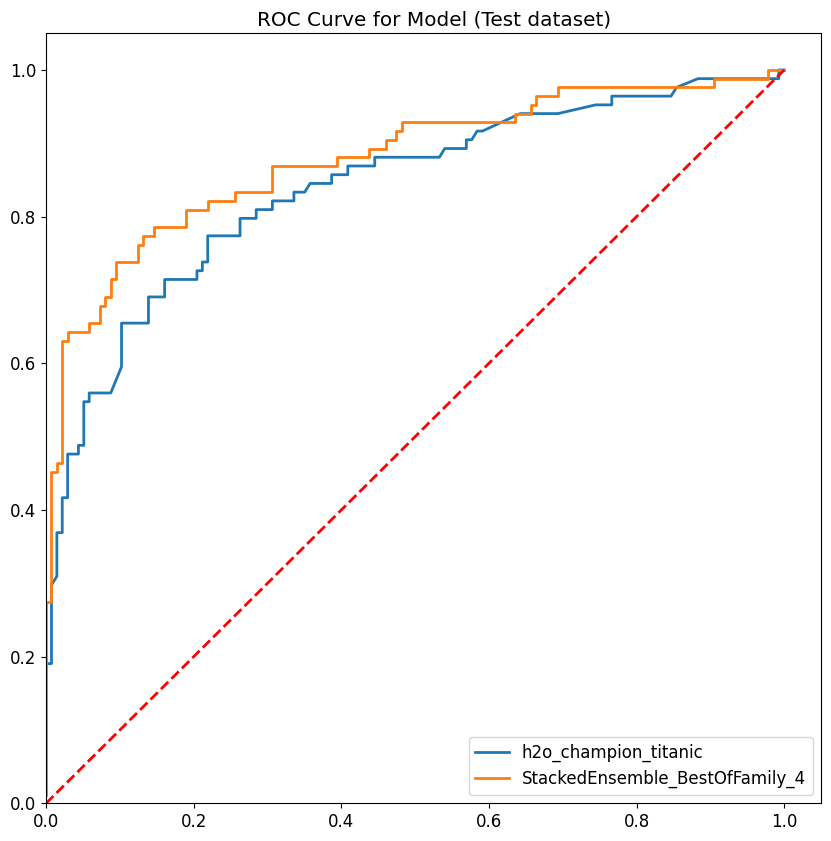

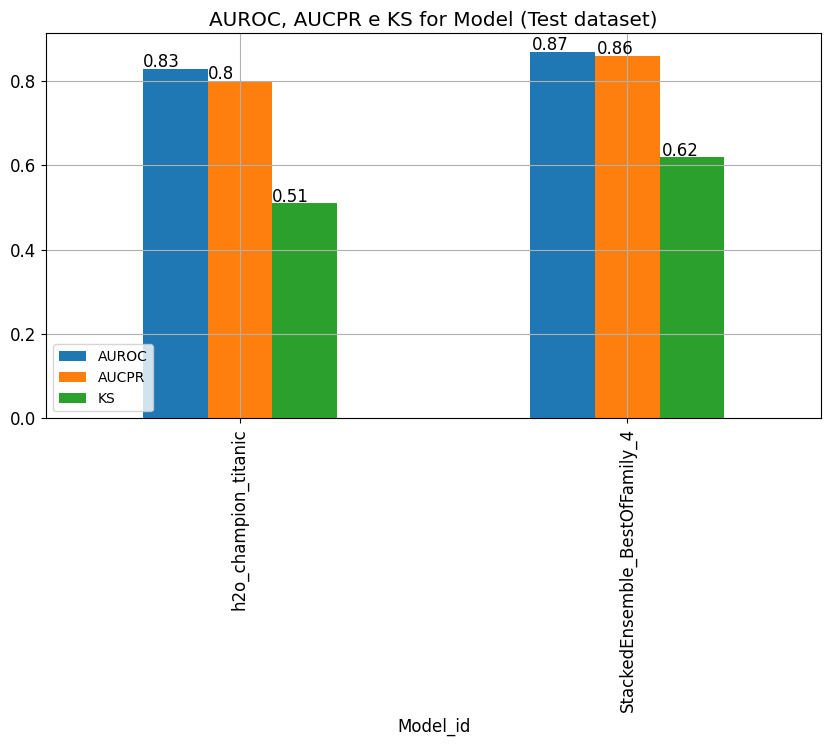

In [30]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('dataset == "test"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [31]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,StackedEnsemble_BestOfFamily_4_AutoML_1_20221117_234854,0.652013,0.878693,0.862852,0.412667,0.625,0.445537
1,0,h2o_champion_titanic_propensity_survive_v1_20221117_234843,0.483557,0.839155,0.806852,0.483301,0.517,0.383971



BEST MODEL: h2o_champion_titanic_propensity_survive_v1_20221117_234843



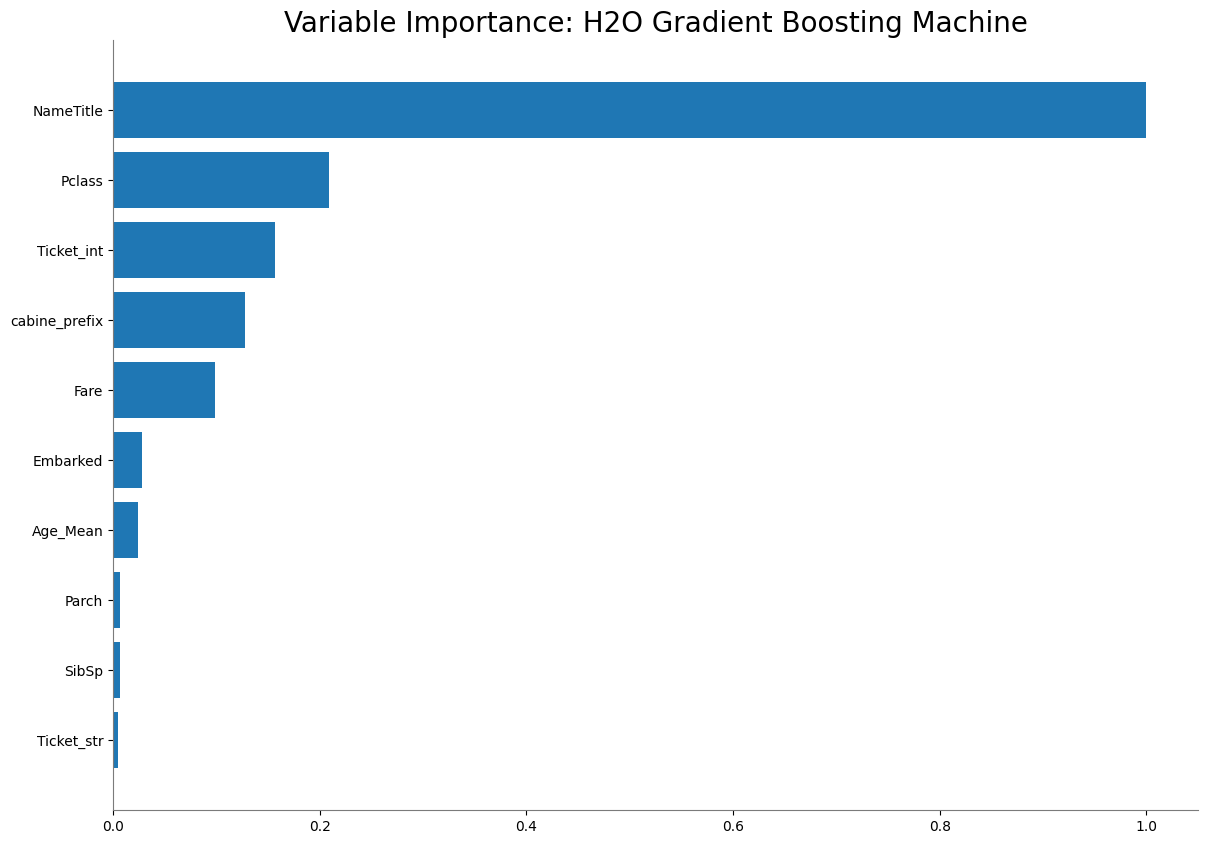

<Figure size 640x480 with 0 Axes>

In [33]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=1

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [34]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [35]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'testset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'testset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'testset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'testset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'testset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


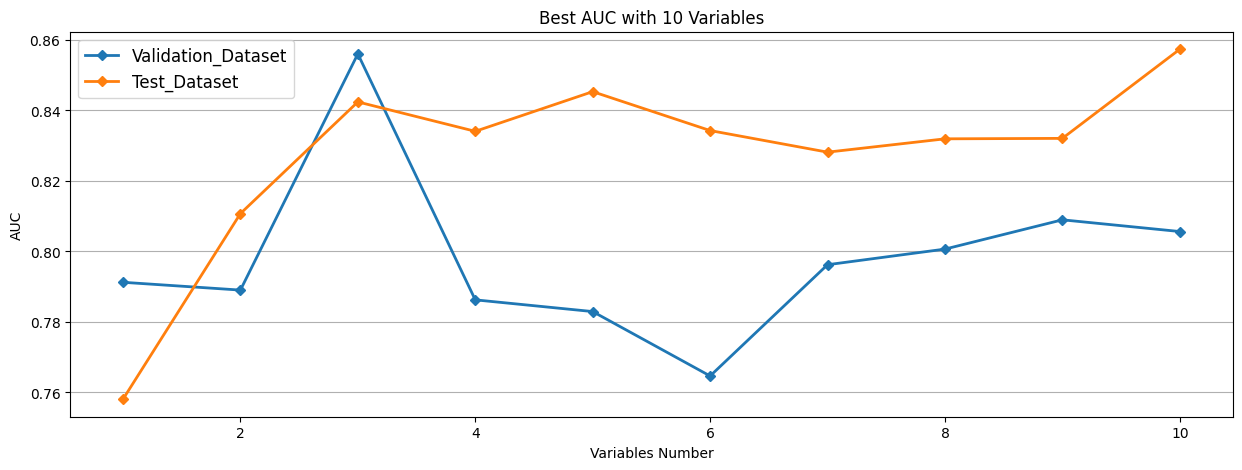

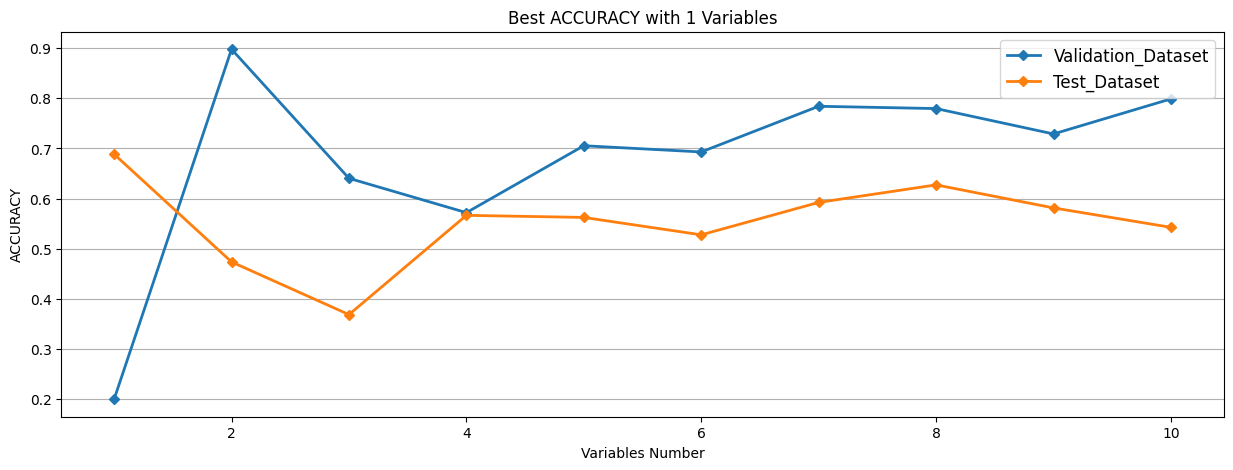

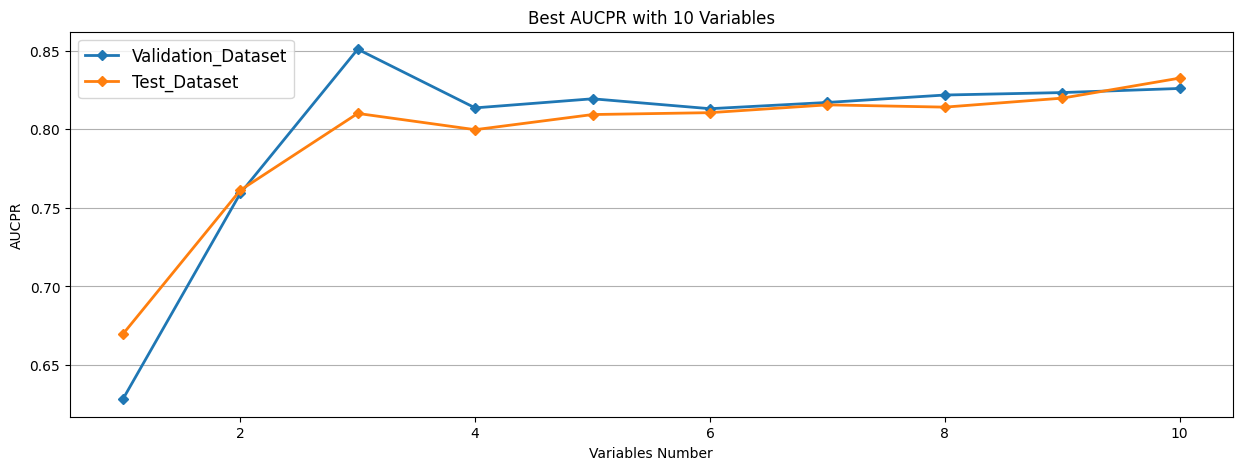

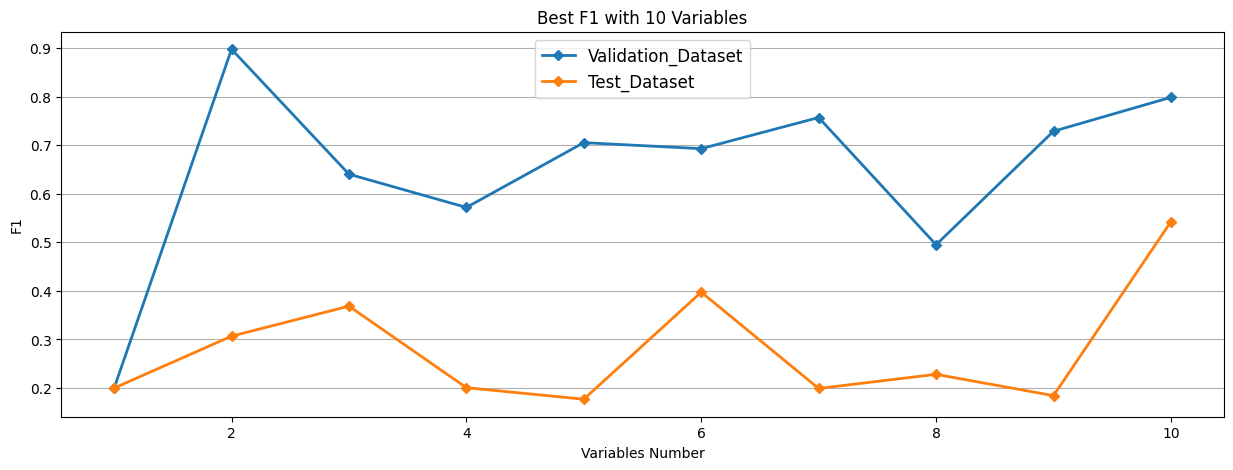

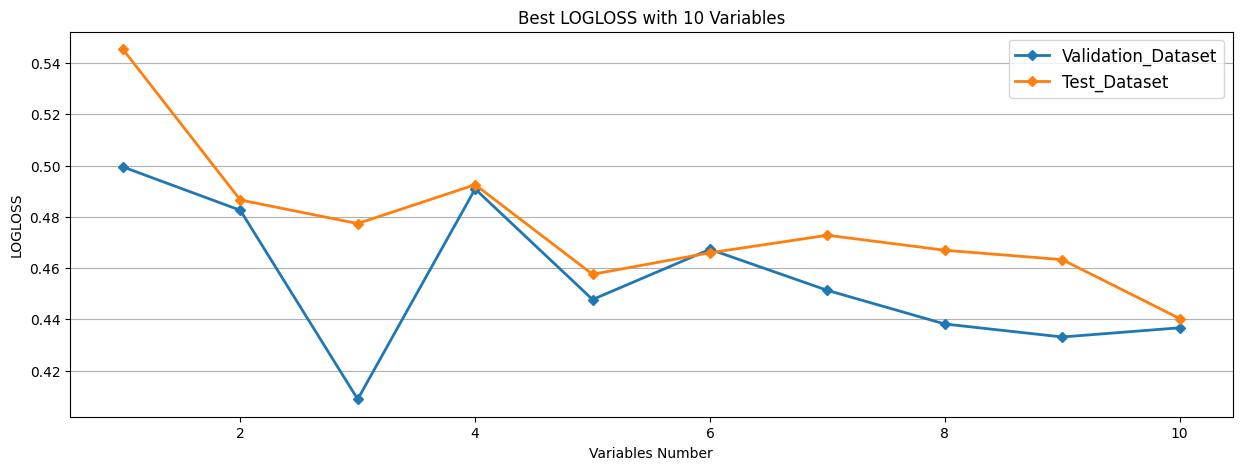

In [36]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [38]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['NameTitle', 'Pclass', 'Ticket_int', 'cabine_prefix', 'Fare', 'Embarked', 'Age_Mean', 'Parch', 'SibSp', 'Ticket_str']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [46]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: /mnt/batch/tasks/shared/LS_root/mounts/clusters/maxdez1/code/Users/maxdez/FIEP-Machine-Learning-e-Computacao-em-Nuvem/output_model/models/best/h2o_champion_titanic_propensity_survive_v1_20221117_234843.zip


Detected 1 unused columns in the input data set: {}


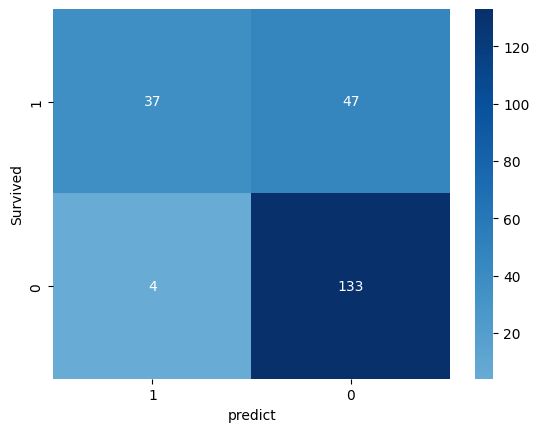

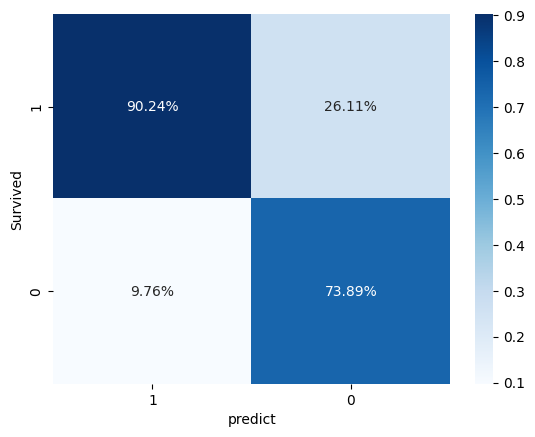

In [41]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions to CSV

In [45]:
df_predict.to_csv('./titanic/df_predict.csv', index=False, header=True)